In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Dropout,Flatten,Dense
from keras.callbacks import EarlyStopping
import os
import cv2
from PIL import Image
import numpy as np

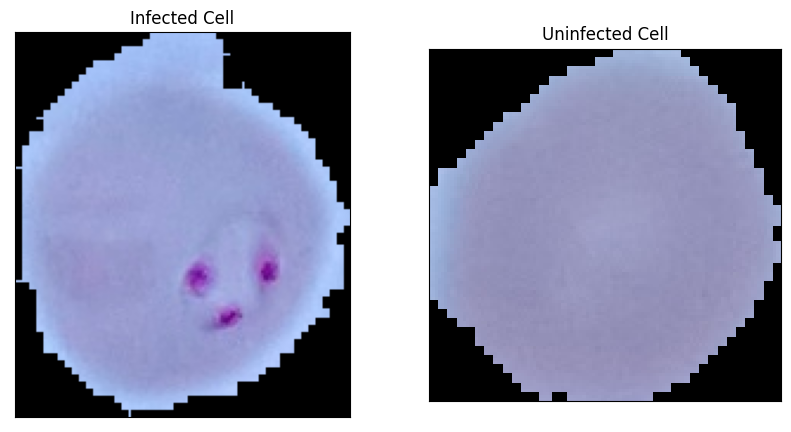

In [4]:
parasitized_image = r"C:\Users\acer\Downloads\Malaria_Dataset\Train\Parasite\C33P1thinF_IMG_20150619_114756a_cell_179.png"
uninfected_image =  r"C:\Users\acer\Downloads\Malaria_Dataset\Train\Uninfected\C1_thinF_IMG_20150604_104722_cell_9.png"

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(parasitized_image))
plt.title('Infected Cell')
plt.xticks([]) , plt.yticks([])


plt.subplot(1,2,2)
plt.imshow(cv2.imread(uninfected_image))
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])


plt.show()

In [5]:
Size = 128
data = []
label = []

In [6]:
path_parasitized = r'C:\Users\acer\Downloads\Malaria_Dataset\Train\Parasite'

for image in os.listdir(path_parasitized):
    img = cv2.imread(os.path.join(path_parasitized,image))
    img = Image.fromarray(img,'RGB')
    img = img.resize((Size,Size))
    data.append(np.array(img))
    label.append(1)

In [7]:
path_uninfected = r'C:\Users\acer\Downloads\Malaria_Dataset\Train\Uninfected'

for image in os.listdir(path_uninfected):
    img = cv2.imread(os.path.join(path_uninfected,image))
    img = Image.fromarray(img,'RGB')
    img = img.resize((Size,Size))
    data.append(np.array(img))
    label.append(0)

In [8]:
data = np.array(data)
label = np.array(label)

In [9]:
print('Size of data',data.shape)
print('Size of label',label.shape)

Size of data (416, 128, 128, 3)
Size of label (416,)


In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test= train_test_split(data,label,test_size=0.20,random_state=0)
print('The train shape is', X_train.shape)
print('The test shape is', X_test.shape)

The train shape is (332, 128, 128, 3)
The test shape is (84, 128, 128, 3)


In [11]:
from keras.utils import normalize
X_train=normalize(X_train,axis=1)
X_test=normalize(X_test,axis=1)

In [12]:
INPUT_SHAPE = (Size, Size, 3)

In [13]:
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3,3),activation='relu',kernel_initializer = 'he_uniform'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3,3),activation='relu',kernel_initializer = 'he_uniform'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 30, 32)        0

In [15]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
history=model.fit(X_train,Y_train,
                  batch_size=16,
                  verbose=1,
                  epochs=30,
                  validation_data=(X_test,Y_test),
                  shuffle = False,
                  callbacks=[early_stop]
                  )

In [21]:
model.save('malaria_model.h5')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
n=5  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model.predict(input_img))
print("The actual label for this image is: ", Y_test[n])

In [39]:
from keras.models import load_model
# load model
model = load_model('malaria_model.h5')

In [40]:
_, acc = model.evaluate(X_test, Y_test)
print("Accuracy = ", (acc * 100.0), "%")

3/3 [==============================] - 9s 295ms/step - loss: 0.2572 - accuracy: 0.9048
Accuracy =  90.47619104385376 %


In [41]:
threshold=0.59
Y_pred = (model.predict(X_test)>=threshold).astype(int)

3/3 [==============================] - 1s 93ms/step


In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test,Y_pred)
print(cm)

[[36  3]
 [ 4 41]]


Text(58.222222222222214, 0.5, 'actual')

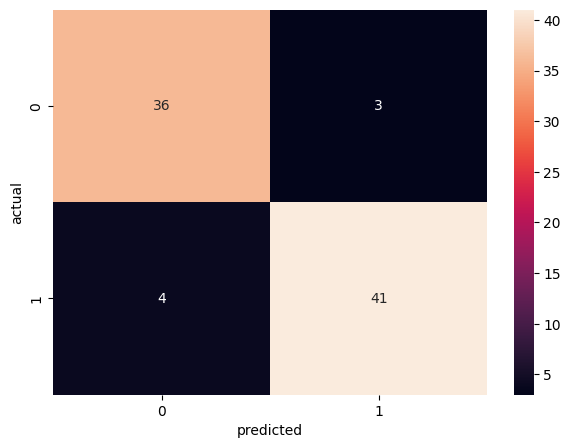

In [43]:
plt.figure(figsize=(7,5))
sns.heatmap(cm,annot=True)
plt.xlabel('predicted')
plt.ylabel('actual')

In [ ]:
from sklearn.metrics import roc_curve
Y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(Y_test, Y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [ ]:
import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds'])

# SVM in CNN

In [11]:
from keras.regularizers import l2

In [12]:
model2 = Sequential()
model2.add(Conv2D(16,(3,3),activation='relu',input_shape=INPUT_SHAPE))
model2.add(MaxPooling2D(2,2))

model2.add(Conv2D(32,(3,3),activation='relu',kernel_initializer = 'he_uniform'))
model2.add(MaxPooling2D(2,2))

model2.add(Conv2D(64,(3,3),activation='relu',kernel_initializer = 'he_uniform'))
model2.add(MaxPooling2D(2,2))

model2.add(Flatten())
model2.add(Dense(64,activation='relu'))
model2.add(Dropout(0.5))

model2.add(Dense(1,kernel_regularizer=l2(0.01),activation='linear'))

In [13]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [14]:
model2.compile(optimizer='adam',loss='hinge',metrics=['accuracy'])

In [19]:
history2=model2.fit(X_train,Y_train,
                  batch_size=16,
                  verbose=1,
                  epochs=30,
                  validation_data=(X_test,Y_test),
                  shuffle = False,
                  callbacks=[early_stop]
                  )

Epoch 1/30
21/21 [==============================] - 6s 297ms/step - loss: 0.6542 - accuracy: 0.6928 - val_loss: 0.5109 - val_accuracy: 0.6905
Epoch 2/30
21/21 [==============================] - 6s 278ms/step - loss: 0.5986 - accuracy: 0.7259 - val_loss: 0.4048 - val_accuracy: 0.8333
Epoch 3/30
21/21 [==============================] - 6s 267ms/step - loss: 0.4462 - accuracy: 0.7651 - val_loss: 0.7177 - val_accuracy: 0.7619
Epoch 4/30
21/21 [==============================] - 5s 234ms/step - loss: 0.4688 - accuracy: 0.8102 - val_loss: 0.3526 - val_accuracy: 0.8690
Epoch 5/30
21/21 [==============================] - 5s 231ms/step - loss: 0.3267 - accuracy: 0.8735 - val_loss: 0.2527 - val_accuracy: 0.8810
Epoch 6/30
21/21 [==============================] - 5s 232ms/step - loss: 0.2740 - accuracy: 0.8645 - val_loss: 0.3253 - val_accuracy: 0.8929
Epoch 7/30
21/21 [==============================] - 5s 241ms/step - loss: 0.2421 - accuracy: 0.8886 - val_loss: 0.2591 - val_accuracy: 0.9048


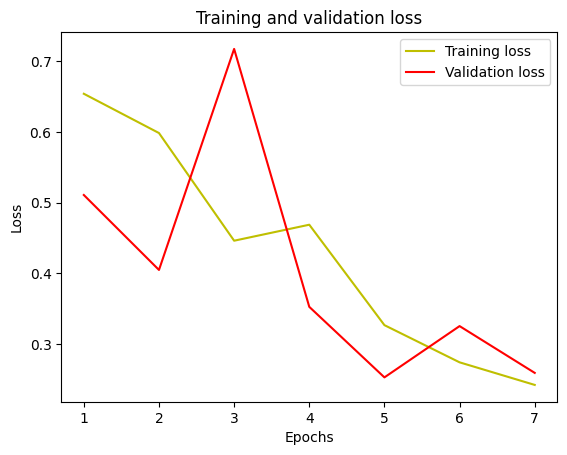

In [20]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

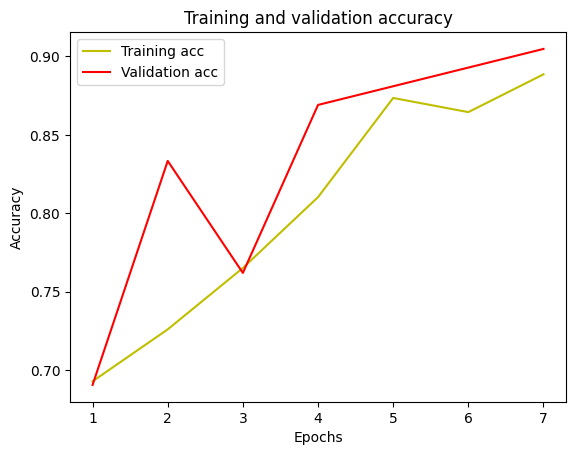

In [21]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [27]:
model2.save('malaria_SVM_model2.h5')

1/1 [==============================] - 1s 1s/step
The prediction for this image is:  [[-0.746456]]
The actual label for this image is:  0


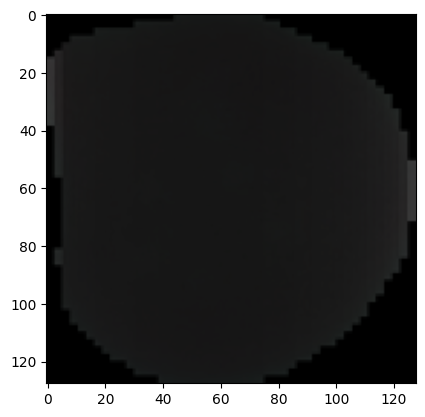

In [28]:
n=5  #Select the index of image to be loaded for testing
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
print("The prediction for this image is: ", model2.predict(input_img))
print("The actual label for this image is: ", Y_test[n])

In [29]:
_, acc = model2.evaluate(X_test, Y_test)
print("Accuracy = ", (acc * 100.0), "%")

3/3 [==============================] - 0s 113ms/step - loss: 0.2591 - accuracy: 0.9048
Accuracy =  90.47619104385376 %


In [31]:
threshold=0.5
Y_pred2 = (model2.predict(X_test)>=threshold).astype(int)

3/3 [==============================] - 1s 120ms/step


In [32]:
from sklearn.metrics import confusion_matrix
cm2 = confusion_matrix(Y_test,Y_pred2)
print(cm2)

[[38  1]
 [ 7 38]]


Text(58.222222222222214, 0.5, 'actual')

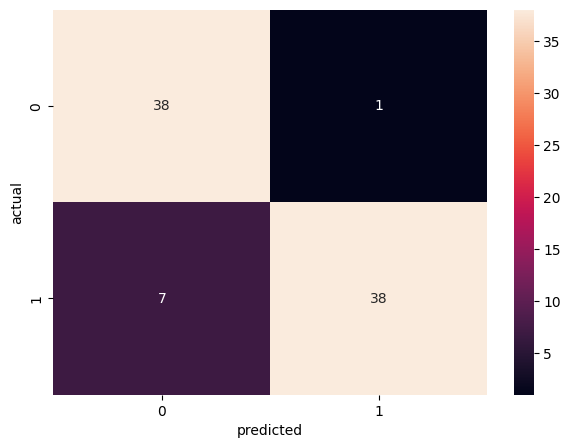

In [34]:
plt.figure(figsize=[7,5])
sns.heatmap(cm2,annot=True)
plt.xlabel('predicted')
plt.ylabel('actual')

3/3 [==============================] - 0s 116ms/step


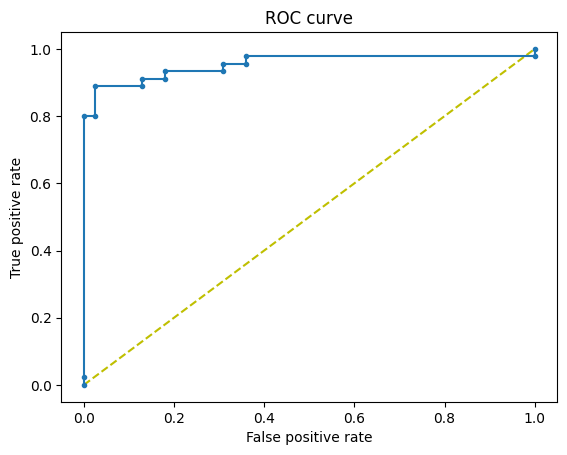

In [37]:
from sklearn.metrics import roc_curve
Y_preds2 = model2.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(Y_test, Y_preds2)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [38]:
import pandas as pd
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds'])

Ideal threshold is:  5   -0.13446
Name: thresholds, dtype: float32
